<a href="https://colab.research.google.com/github/gomescheelsy03/inst414-asteroid-family-analysis/blob/main/module3_supervised_learning_asteroid_communities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 3: Supervised Learning for Asteroid Community Prediction
## Project Context

This notebook implements the supervised learning component of the INST414 final project.
Building on the similarity-based network analysis from Module 2, the goal of this module
is to train machine learning models that predict asteroid community membership using
orbital and physical characteristics.

Communities identified through network science represent fine-grained similarity
groups that extend beyond the broad clusters identified in Module 4. By predicting
these community labels directly from asteroid features, this module evaluates whether
the structural patterns discovered in the network can be learned and generalized
through supervised models.

## Data Sources

- **Cleaned asteroid dataset** produced in Module 4 (orbital and physical features)
- **Community labels** produced in Module 2 (network-based group assignments)

## Objective

To evaluate how well supervised learning models can predict asteroid community membership
and to assess which orbital and physical features are most informative for distinguishing
between network-derived asteroid groups.


In [1]:

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Paths + settings

ARTIFACT_DIR = "./asteroid_m3_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

SEED = 42
np.random.seed(SEED)

# Upload these into the Module 3 Colab session (/content)
FEATURES_PATH = "/content/asteroids_clean_full.csv"
LABELS_PATH   = "/content/node_labels_module2.csv"

print("Artifacts will be saved to:", os.path.abspath(ARTIFACT_DIR))



Artifacts will be saved to: /content/asteroid_m3_artifacts


In [3]:
# Load data

assert os.path.exists(FEATURES_PATH), f"Missing features file: {FEATURES_PATH}"
assert os.path.exists(LABELS_PATH),   f"Missing labels file: {LABELS_PATH}"

features_df = pd.read_csv(FEATURES_PATH, low_memory=True)
labels_df   = pd.read_csv(LABELS_PATH)

print("features_df:", features_df.shape)
print("labels_df:", labels_df.shape)

# Save schema snapshots
with open(os.path.join(ARTIFACT_DIR, "features_schema_snapshot.json"), "w") as f:
    json.dump({"shape": features_df.shape, "columns": features_df.columns.tolist()}, f, indent=2)

with open(os.path.join(ARTIFACT_DIR, "labels_schema_snapshot.json"), "w") as f:
    json.dump({"shape": labels_df.shape, "columns": labels_df.columns.tolist()}, f, indent=2)

features_df: (131237, 8)
labels_df: (4873, 2)


In [4]:
# Choose join key automatically

# labels_df must have: node, community
assert "node" in labels_df.columns, "labels_df must contain a 'node' column"
assert "community" in labels_df.columns, "labels_df must contain a 'community' column"

PREFERRED_ID_COLS = ["id", "spkid", "full_name", "name", "__index__"]

id_col = None
for c in PREFERRED_ID_COLS:
    if c in features_df.columns:
        id_col = c
        break

if id_col is None:
    # fallback to index if none exist
    id_col = "__index__"
    features_df[id_col] = np.arange(len(features_df))

print("Using join key in features_df:", id_col)

# Normalize types to string for safe merge
features_df[id_col] = features_df[id_col].astype(str)
labels_df["node"] = labels_df["node"].astype(str)

# Merge
df = features_df.merge(labels_df, left_on=id_col, right_on="node", how="inner")
print("Merged df:", df.shape)

# Save merged snapshot
with open(os.path.join(ARTIFACT_DIR, "merged_schema_snapshot.json"), "w") as f:
    json.dump({"shape": df.shape, "columns": df.columns.tolist()}, f, indent=2)


Using join key in features_df: __index__
Merged df: (4873, 11)


In [5]:
# Define features (X) and target (y)

# Use the same features from Modules 2/4, if available
candidate_features = ["a", "e", "i", "q", "moid", "diameter", "albedo"]
available_features = [c for c in candidate_features if c in df.columns]

if not available_features:
    raise ValueError(f"None of the candidate features are available. Found columns: {df.columns.tolist()}")

print("Using features:", available_features)

# Drop rows with missing values in model features or community
model_df = df.dropna(subset=available_features + ["community"]).copy()

# Ensure target is integer
model_df["community"] = model_df["community"].astype(int)

X = model_df[available_features].values
y = model_df["community"].values

print("Modeling rows:", len(model_df))
print("Number of classes (communities):", len(np.unique(y)))
print(model_df["community"].value_counts().sort_index())


Using features: ['a', 'e', 'i', 'q', 'moid', 'diameter', 'albedo']
Modeling rows: 4873
Number of classes (communities): 5
community
0    1849
1    1808
2    1060
3     127
4      29
Name: count, dtype: int64


In [6]:
# Train/Test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=SEED,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

# Save split sizes
with open(os.path.join(ARTIFACT_DIR, "split_summary.json"), "w") as f:
    json.dump(
        {
            "train_rows": int(X_train.shape[0]),
            "test_rows": int(X_test.shape[0]),
            "features": available_features,
            "n_classes": int(len(np.unique(y)))
        },
        f, indent=2
    )

Train size: (3654, 7) Test size: (1219, 7)


In [7]:
# Baseline model (most-frequent)

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)
baseline_pred = baseline.predict(X_test)

baseline_acc = accuracy_score(y_test, baseline_pred)
print("\n=== Baseline (Most Frequent) ===")
print("Accuracy:", round(baseline_acc, 4))

with open(os.path.join(ARTIFACT_DIR, "baseline_metrics.json"), "w") as f:
    json.dump({"accuracy": float(baseline_acc)}, f, indent=2)



=== Baseline (Most Frequent) ===
Accuracy: 0.3798


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression ===
Accuracy: 0.9352
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       463
           1       0.93      0.91      0.92       452
           2       0.95      0.93      0.94       265
           3       0.88      0.94      0.91        32
           4       1.00      1.00      1.00         7

    accuracy                           0.94      1219
   macro avg       0.94      0.95      0.94      1219
weighted avg       0.94      0.94      0.94      1219



<Figure size 600x500 with 0 Axes>

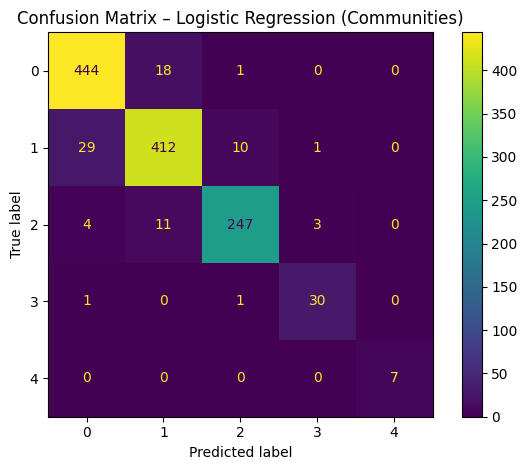

In [8]:
# Model 1: Multinomial Logistic Regression (with scaling)

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=3000,
        multi_class="auto",
        n_jobs=None,
        random_state=SEED
    ))
])

logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)

logreg_acc = accuracy_score(y_test, logreg_pred)
print("\n=== Logistic Regression ===")
print("Accuracy:", round(logreg_acc, 4))
print(classification_report(y_test, logreg_pred))

with open(os.path.join(ARTIFACT_DIR, "logreg_metrics.json"), "w") as f:
    json.dump({"accuracy": float(logreg_acc)}, f, indent=2)

# Confusion matrix plot
cm = confusion_matrix(y_test, logreg_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6, 5))
disp.plot(values_format="d")
plt.title("Confusion Matrix – Logistic Regression (Communities)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "confusion_matrix_logreg.png"), dpi=200)
plt.show()


=== Random Forest ===
Accuracy: 0.9729
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       463
           1       0.97      0.97      0.97       452
           2       0.97      0.95      0.96       265
           3       0.94      0.97      0.95        32
           4       1.00      1.00      1.00         7

    accuracy                           0.97      1219
   macro avg       0.97      0.98      0.97      1219
weighted avg       0.97      0.97      0.97      1219



<Figure size 600x500 with 0 Axes>

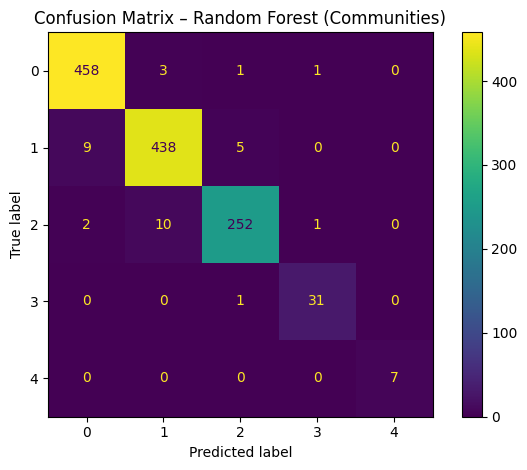

In [9]:
# Model 2: Random Forest (no scaling needed)

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
print("\n=== Random Forest ===")
print("Accuracy:", round(rf_acc, 4))
print(classification_report(y_test, rf_pred))

with open(os.path.join(ARTIFACT_DIR, "rf_metrics.json"), "w") as f:
    json.dump({"accuracy": float(rf_acc)}, f, indent=2)

# Confusion matrix plot
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
plt.figure(figsize=(6, 5))
disp_rf.plot(values_format="d")
plt.title("Confusion Matrix – Random Forest (Communities)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "confusion_matrix_rf.png"), dpi=200)
plt.show()


=== Random Forest Feature Importance ===
    feature  importance
0         a    0.270094
2         i    0.241852
6    albedo    0.181719
4      moid    0.118586
3         q    0.104009
1         e    0.053254
5  diameter    0.030486


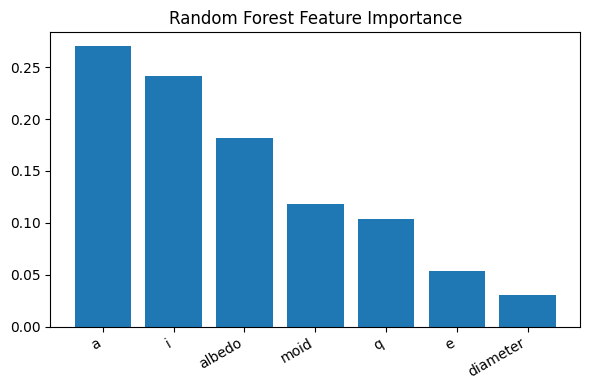

In [10]:
# Feature importance (Random Forest)

importances = rf.feature_importances_
fi = pd.DataFrame({
    "feature": available_features,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\n=== Random Forest Feature Importance ===")
print(fi)

fi.to_csv(os.path.join(ARTIFACT_DIR, "rf_feature_importance.csv"), index=False)

plt.figure(figsize=(6, 4))
plt.bar(fi["feature"], fi["importance"])
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_feature_importance.png"), dpi=200)
plt.show()


In [11]:
# Save predictions for transparency / later analysis

pred_out = model_df.copy()

# Rebuild the same split indices so we can attach test predictions clearly
# We do this by adding a row id and splitting on that.
pred_out = pred_out.reset_index(drop=True)
row_ids = np.arange(len(pred_out))

train_ids, test_ids = train_test_split(
    row_ids,
    test_size=0.25,
    random_state=SEED,
    stratify=pred_out["community"].values
)

# Create a results table for test set only
test_table = pred_out.loc[test_ids, [id_col, "node", "community"] + available_features].copy()
test_table["pred_logreg"] = logreg.predict(test_table[available_features].values)
test_table["pred_rf"] = rf.predict(test_table[available_features].values)

test_table.to_csv(os.path.join(ARTIFACT_DIR, "test_set_predictions.csv"), index=False)

print("\nSaved test predictions to:", os.path.join(ARTIFACT_DIR, "test_set_predictions.csv"))
print("Module 3 complete.")


Saved test predictions to: ./asteroid_m3_artifacts/test_set_predictions.csv
Module 3 complete.
